# Goal: make predictions using predictions from NN

## Outline:
### Train NN on 20% and make predictions

Features were built in the data exploration notebook.

They were selected using XGBClassifier on 20% of the data. XGB performs better using more features than that, so although we may work with the 50-feature dataset for our neural network, we should work with the wider 70-feature dataset for xgboost.

The NN is fed this data and trains on 20% before returning the predictions on the overall dataset. We do not apply the bias correction then. Once we have those features, we train xgboost again and consider this the output of our model.

This procedure can be improved in rigor by using cross validation. It should also produce better predictions which should improve the overall performance since we are stacking.

### Store predictions as images and feed to XGB
### Reshape predictions into the original shape to compute the errors (some NANs need to be thrown out)
### Try out on the testing data

In [192]:
import matplotlib.pyplot as plt
import numpy as  np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set_style('white')

In [193]:
# Load data

data_50 = pd.read_csv('feature_engineered_50.csv',sep = ';')
data_70 = pd.read_csv('feature_engineered_70.csv',sep = ';')
data = pd.read_csv('FULL_DATA.csv',sep =';')
targets = data_50['TARGET']

In [ ]:
# Delete targets, if wanted

del data_50['TARGET']
del data_70['TARGET']
del data['TARGET']

In [18]:
# Load predictions and add them

predictions = pd.read_csv('PREDICTIONS.csv',sep = ';')
data_50['PREDICTIONS'] = predictions
data_70['PREDICTIONS'] = predictions
data['PREDICTIONS'] = predictions

### Tests:
On 20% of the training setm though we tested on 10% as well to make sure the bias 0.15 was not due to overfitting in our selection procedure.
- Without bias, with 50 features, 26.9%
- With bias, with 50 features, 23.86%
- Without bias, with 70 features, 26.8%
- With bias, with 70 features, 23.86%
- Without bias, on full dataset,

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


y = targets.values

X = data_50.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.27029662375831942

In [25]:
y_pred = model.predict(X_test)-0.017
np.mean(np.abs(y_pred - y_test)/(y_test))

0.2390804767419526

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


y = targets.values

X = data_70.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.26948470913340122

In [26]:
y_pred = model.predict(X_test)-0.017
np.mean(np.abs(y_pred - y_test)/(y_test))

0.2390804767419526

In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


y = targets.values

X = data.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.26888023074444672

In [33]:
y_pred = model.predict(X_test)-0.017
np.mean(np.abs(y_pred - y_test)/(y_test))

0.23877337748815022

In [36]:
np.mean(np.abs(y_pred*0.999 - y_test)/(y_test))

0.23873175275374378

In [73]:
new_y_pred = y_pred - 0.03*np.exp(-y_pred/10.0)

In [74]:
np.mean(np.abs(new_y_pred - y_test)/(y_test))

0.25664612213668281

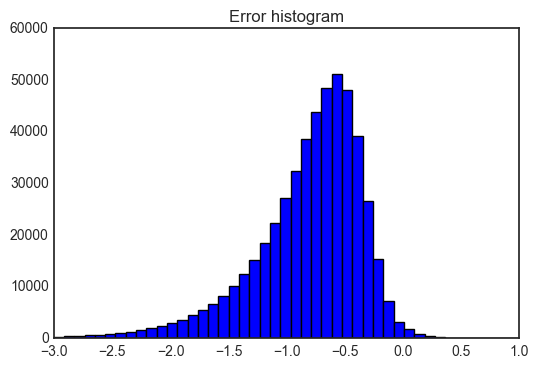

In [37]:
plt.title('Error histogram')
plt.hist(np.log10(np.abs(y_pred - y_test)/y_test),bins = 100)
plt.xlim(-3.0,1.0)
plt.show()

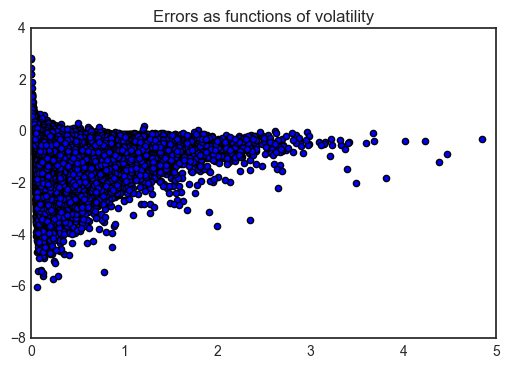

In [38]:
plt.title('Errors as functions of volatility')
plt.scatter(y_test,np.log10(np.abs(y_pred - y_test)/y_test))
plt.xlim(-0.0,5.0)
plt.show()

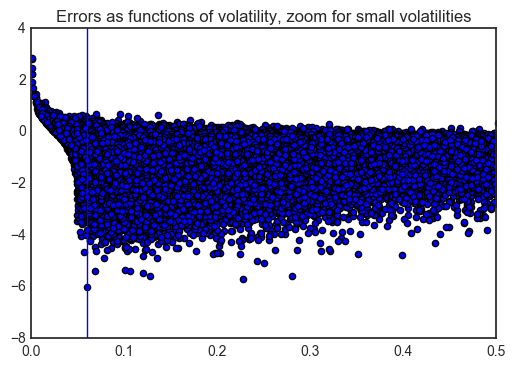

In [39]:
plt.title('Errors as functions of volatility, zoom for small volatilities')
plt.scatter(y_test,np.log10(np.abs(y_pred - y_test)/y_test))
plt.axvline(x = 0.06)
plt.xlim(-0.0,0.5)
plt.show()

In [40]:
errs = np.log10(np.abs(y_pred - y_test)/y_test)

np.mean(y_test <= 0.06)

0.046816527224187755

In [41]:
# Error for y test bigger than 0.1
print(np.mean(10**errs[y_test > 0.06]))

# Error for y test smaller than 0.1
print(np.mean(10**errs[y_test <= 0.06]))

0.221759957104
0.585166245282


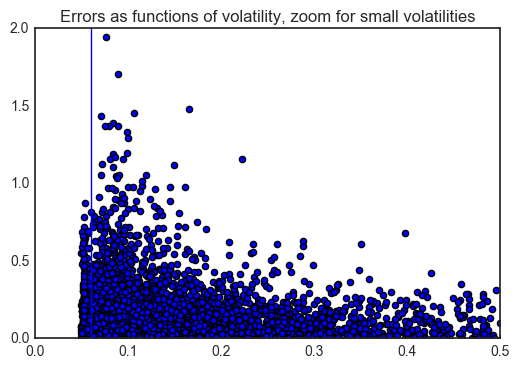

In [42]:
plt.title('Errors as functions of volatility, zoom for small volatilities')
plt.scatter(y_pred,np.log10(np.abs(y_pred - y_test)/y_test))
plt.axvline(x = 0.06)
plt.xlim(-0.0,0.5)
plt.ylim(0.0,2.0)
plt.show()

In [43]:
new_y_pred = (y_pred - y_pred*0.1*(y_pred <= 0.1))

In [44]:
np.mean(np.abs(new_y_pred - y_test)/(y_test))

0.24473378914018826

In [45]:
np.mean(np.abs((0.04 - y_test[y_test <= 0.05])/y_test[y_test <= 0.05]))

0.28797569426040803

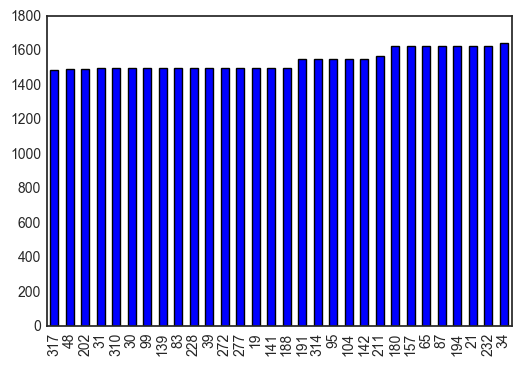

In [108]:
prop_products = data['product_id'].value_counts()
prop_products.sort_values(ascending = True)[0:30].plot(kind = 'bar')
plt.show()

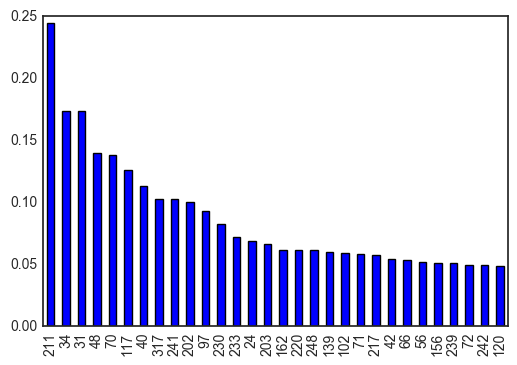

In [122]:
prop_low_vol = data.loc[targets <= 0.05]['product_id'].value_counts()/data['product_id'].value_counts()
prop_low_vol.sort_values(ascending = False)[0:30].plot(kind = 'bar')
plt.show()

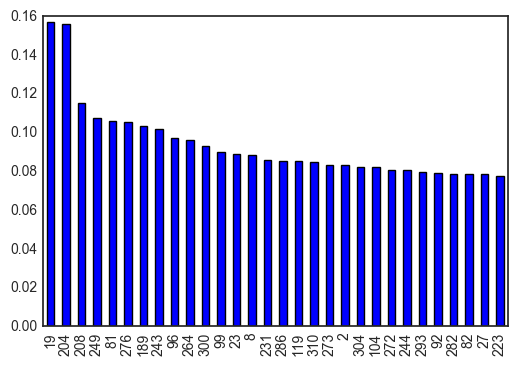

In [130]:
prop_low_vol = data.loc[targets >= 0.5]['product_id'].value_counts()/data['product_id'].value_counts()
prop_low_vol.sort_values(ascending = False)[0:30].plot(kind = 'bar')
plt.show()

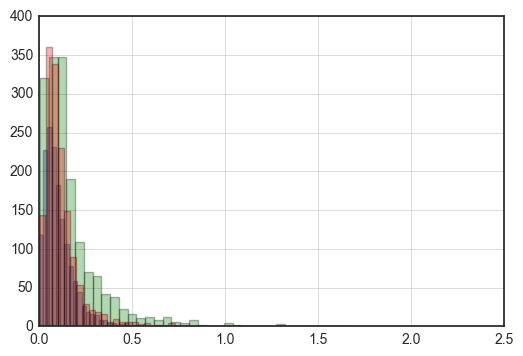

In [141]:
plt.clf()

data.loc[data['product_id'] == 211]['TARGET'].hist(bins = 50,alpha = 0.3)
data.loc[data['product_id'] == 34]['TARGET'].hist(bins = 50,alpha = 0.3)
data.loc[data['product_id'] == 31]['TARGET'].hist(bins = 50,alpha = 0.3)

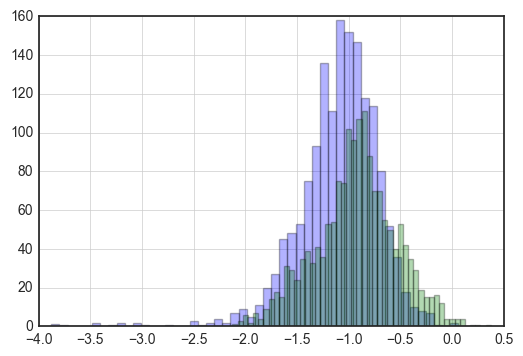

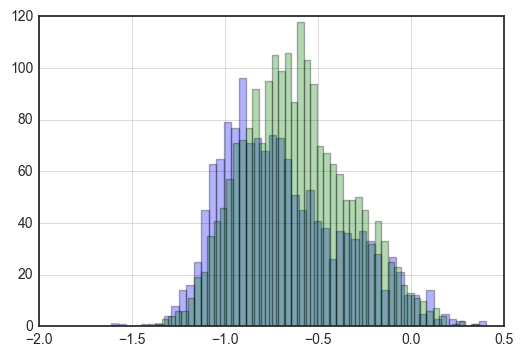

In [146]:
plt.clf()
np.log10(data.loc[data['product_id'] == 211]['TARGET']).hist(bins = 50,alpha = 0.3)
np.log10(data.loc[data['product_id'] == 34]['TARGET']).hist(bins = 50,alpha = 0.3)

plt.show()

np.log10(data.loc[data['product_id'] == 19]['TARGET']).hist(bins = 50,alpha = 0.3)
np.log10(data.loc[data['product_id'] == 204]['TARGET']).hist(bins = 50,alpha = 0.3)

In [194]:
means = []
stds = []
products = []
numbers = []

for key in range(1,318):
    means += [(np.mean(np.log10(data.loc[data['product_id'] == key]['TARGET'])))]
    stds += [(np.std(np.log10(data.loc[data['product_id'] == key]['TARGET'])))]
    products += [key]
    numbers += [len(data.loc[data['product_id'] == key])]

In [195]:
summary = pd.DataFrame()
summary['MEAN'] = means
summary['STD'] = stds
summary['PRODUCT'] = products
summary['NUMBER'] = numbers

In [196]:
summary = summary.sort_values(by = 'MEAN')

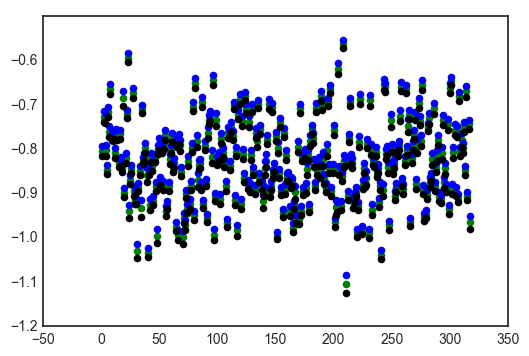

In [197]:
plt.scatter(summary['PRODUCT'],summary['MEAN'],color = 'g')
plt.scatter(summary['PRODUCT'],summary['STD']*1.96/np.sqrt(summary['NUMBER']) + summary['MEAN'],color = 'b')
plt.scatter(summary['PRODUCT'],-summary['STD']*1.96/np.sqrt(summary['NUMBER']) + summary['MEAN'],color = 'k')
plt.show()

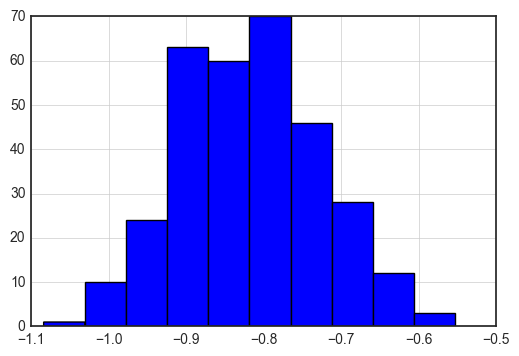

In [186]:
(summary['STD']*1.96/np.sqrt(summary['NUMBER']) + summary['MEAN']).hist(bins = 10)

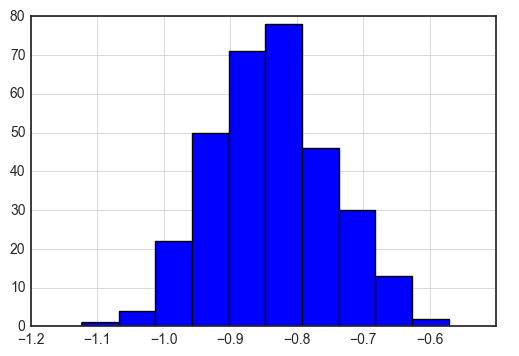

In [187]:
(-summary['STD']*1.96/np.sqrt(summary['NUMBER']) + summary['MEAN']).hist(bins = 10)

# Some products have consistently high volatilities while others have consistenly low volatilities, even accounting for their standard deviations. It is nuts to treat them all the same way.

## Lets try splitting the dataset depending on the products

In [208]:
products_low = summary.loc[(summary['STD']*1.96/np.sqrt(summary['NUMBER']) + summary['MEAN'] <= -0.9)]['PRODUCT'].values

In [209]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data.loc[data['product_id'] == products_low[0]]['TARGET'].values

del copy['TARGET']
             
X = copy.loc[data['product_id'] == products_low[0]].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

2.3061227166158611

# Contrast this with training on the overall dataset

In [210]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.27085032614242632

In [211]:
y_pred = model.predict(copy.loc[data['product_id'] == products_low[0]].values)
y_test =  data.loc[data['product_id'] == products_low[0]]['TARGET'].values
np.mean(np.abs(y_pred - y_test)/(y_test))

3.2709783887237793

# There is a clear difference!! We should test on others

In [212]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data.loc[data['product_id'] == products_low[1]]['TARGET'].values

del copy['TARGET']
             
X = copy.loc[data['product_id'] == products_low[1]].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.37816707992942811

In [213]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.27085032614242632

In [214]:
y_pred = model.predict(copy.loc[data['product_id'] == products_low[1]].values)
y_test =  data.loc[data['product_id'] == products_low[1]]['TARGET'].values
np.mean(np.abs(y_pred - y_test)/(y_test))

0.42416857376419714

# What if you had more data to train the xgboost model? Maybe we dont have access to low volatility data in the overall training

In [215]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.27224032347294347

In [218]:
y_pred = model.predict(copy.loc[data['product_id'] == products_low[1]].values)
y_test =  data.loc[data['product_id'] == products_low[1]]['TARGET'].values
np.mean(np.abs(y_pred - y_test)/(y_test))

0.4206611882341903

# What is the effect of bias here?

In [220]:
# On full model, 50% data

y_pred = model.predict(copy.loc[data['product_id'] == products_low[1]].values)
y_test =  data.loc[data['product_id'] == products_low[1]]['TARGET'].values
np.mean(np.abs(y_pred - y_test-0.02)/(y_test))

0.34856341814935698

In [221]:
# On partial model, 80% data
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data.loc[data['product_id'] == products_low[1]]['TARGET'].values

del copy['TARGET']
             
X = copy.loc[data['product_id'] == products_low[1]].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.37816707992942811

In [222]:
y_pred = model.predict(copy.loc[data['product_id'] == products_low[1]].values)
y_test =  data.loc[data['product_id'] == products_low[1]]['TARGET'].values
np.mean(np.abs(y_pred - y_test-0.02)/(y_test))

0.31864602324655406

# We need to look at partial distributiions to see if the low vol effect can be witnessed or if this is just overfitting to the training data

,MEAN,STD,PRODUCT,NUMBER
210,-1.103621,0.401254,211,1566
240,-1.038482,0.236382,241,2089
39,-1.033723,0.229977,40,2093
30,-1.030315,0.320700,31,1498
69,-0.998699,0.301026,70,1672
47,-0.995881,0.295051,48,1493
150,-0.994727,0.206305,151,2117
96,-0.993072,0.254612,97,1667
65,-0.992885,0.229828,66,1652
229,-0.989784,0.238418,230,2115


In [226]:
means = []
stds = []
products = []
numbers = []

for key in range(1,318):
    means += [(np.mean(np.log10(data.loc[data['product_id'] == key]['TARGET']).values[0:500]))]
    stds += [(np.std(np.log10(data.loc[data['product_id'] == key]['TARGET']).values[0:500]))]
    products += [key]
    numbers += [len(data.loc[data['product_id'] == key].values[0:500])]

In [227]:
summary = pd.DataFrame()
summary['MEAN'] = means
summary['STD'] = stds
summary['PRODUCT'] = products
summary['NUMBER'] = numbers

In [231]:
summary = summary.sort_values(by = 'MEAN')
summary

,MEAN,STD,PRODUCT,NUMBER
210,-1.115703,0.443129,211,500
240,-1.036306,0.238645,241,500
39,-1.032454,0.236524,40,500
30,-1.021064,0.321106,31,500
229,-0.997593,0.246320,230,500
69,-0.995370,0.301306,70,500
47,-0.991707,0.290945,48,500
150,-0.989378,0.211380,151,500
219,-0.988141,0.221715,220,500
65,-0.987708,0.230706,66,500


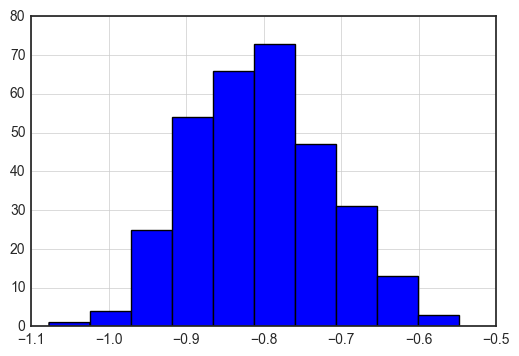

In [230]:
(summary['STD']*1.96/np.sqrt(summary['NUMBER']) + summary['MEAN']).hist(bins = 10)

# So no! If we look at 500 observations for each, we still have similar trends... This indicates that we should clearly split our dataset depending on which products are being considered.

## We should then look at the error that this yields...

In [235]:
np.where(data['product_id'],[1,2])

ValueError: either both or neither of x and y should be given

In [232]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.copy()

y = data.loc[data['product_id'] == ident]['TARGET'].values

del copy['TARGET']

X = copy.loc[data['product_id'] ==ident].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.8,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
print(np.mean(np.abs(y_pred - y_test)/(y_test)))

0.265182051375
0.280231305076
0.269139468738
0.28861203736
0.300024624015
0.252282394535
0.273635848855
0.272920428424
0.259941970018
0.278879175675
0.24768023412
0.289944012718
0.313800507795
0.25155066806
0.24216063663
0.287412380829
0.236048764721
0.30135890175
0.33745426338
0.304868861215
0.245953028349
0.256278504236
0.300573774334
0.327476137977
0.25839023193
0.255885530625
0.277547259028
0.286478813956
0.269508740761
0.332338184428
0.648254391815
0.291093103893
0.269846114457
0.346047928751
0.271667569589
0.259672661396
0.262359720388
0.317011423515
0.270496290591
0.344652350126
0.293692698445
0.302863750144
0.269474195841
0.273719020944
0.300984815273
0.239413302926
0.333000955367
0.352401292159
0.290326871655
0.291380411819
0.278546937816
0.270627022747
0.280906184059
0.280073234015
0.270774234


KeyboardInterrupt: 

In [237]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.loc[data['TARGET'] >= 0.05].copy()

y = copy['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.25011337115845894

In [238]:
y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test-0.02)/(y_test))

0.22407698751008831

In [1]:
data

NameError: name 'data' is not defined

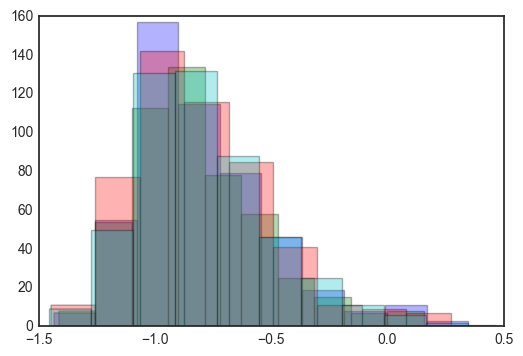

In [13]:
plt.hist(np.log10(data.loc[data['product_id'] == 1]['TARGET'].values[0:500]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 1]['TARGET'].values[500:1000]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 1]['TARGET'].values[1000:1500]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 1]['TARGET'].values[1500:2000]),alpha = 0.3)
plt.show()

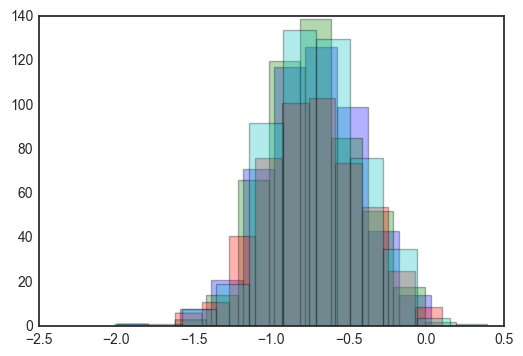

In [14]:
plt.hist(np.log10(data.loc[data['product_id'] == 2]['TARGET'].values[0:500]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 2]['TARGET'].values[500:1000]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 2]['TARGET'].values[1000:1500]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 2]['TARGET'].values[1500:2000]),alpha = 0.3)
plt.show()

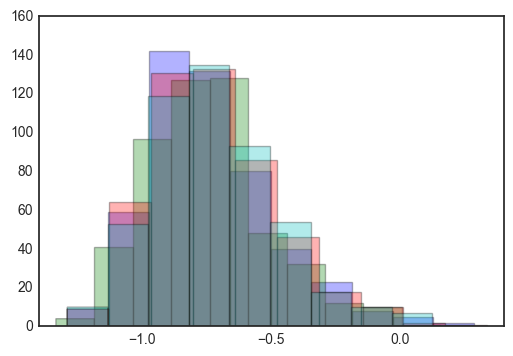

In [15]:
plt.hist(np.log10(data.loc[data['product_id'] == 3]['TARGET'].values[0:500]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 3]['TARGET'].values[500:1000]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 3]['TARGET'].values[1000:1500]),alpha = 0.3)
plt.hist(np.log10(data.loc[data['product_id'] == 3]['TARGET'].values[1500:2000]),alpha = 0.3)
plt.show()

# Surprisingly, the distributions are relatively stable; for example let us measure the error made when taking the median for a product as a prediction

In [18]:
m = np.median(data.loc[data['product_id'] == 3]['TARGET'].values[0:500])

In [31]:
m = np.median(data.loc[data['product_id'] == 3]['TARGET'].values[0:500])

np.mean(np.abs((m - data.loc[data['product_id'] == 3]['TARGET'].values))/
        data.loc[data['product_id'] == 3]['TARGET'].values)

0.40297182254728742

# Idea implementation of sport statistics

## Masseys method

We can adapat Masseys method by considering that when a stock outperforms similar stocks, it is being 'agressive' in volatility while we say the opposite when it is underperforming and we consider it 'defensive'.

The idea is that we assign a ranking depending on the differential between points scored by two different teams. Therefore in the analogy one day will correspond to one match. We compute the differential with other assets and consider this the score of matches from that day.

Then,we invert the matrix obtained to obtain the scores.

This doesnt work and produces degenerescences.

In [102]:
fuse = pd.read_csv('fused_Y.csv',sep = ';')

In [103]:
del fuse['date']

In [106]:
fuse = fuse.fillna(0.0)
w = fuse.values

In [108]:
y = np.sum(w,axis = 1) - 2*fuse['TARGET_1']

In [114]:
fuse.values >= fuse['TARGET_1'].values

ValueError: operands could not be broadcast together with shapes (2117,318) (2117,) 

In [140]:
w = np.zeros((fuse.shape))

for k in range(w.shape[1]):
    w[:,k] = (fuse.values[:,k] >= fuse['TARGET_1'])*1-(fuse.values[:,k] < fuse['TARGET_1'])*1

In [141]:
c = 1e-1

X = np.dot(w.T,w) + c*np.eye(w.shape[1])

In [142]:
y = np.sum(w,axis = 1)
y = np.dot(w.T,y)

In [143]:
rankings = np.dot(np.linalg.inv(X),y)

In [144]:
w*rankings

array([[ 0.99889706, -0.99996325,  0.9999978 , ..., -1.0000179 ,
         0.99990146, -1.00000832],
       [ 0.99889706, -0.99996325,  0.9999978 , ..., -1.0000179 ,
        -0.99990146, -1.00000832],
       [ 0.99889706, -0.99996325, -0.9999978 , ..., -1.0000179 ,
        -0.99990146, -1.00000832],
       ..., 
       [ 0.99889706,  0.99996325,  0.9999978 , ...,  1.0000179 ,
        -0.99990146, -1.00000832],
       [ 0.99889706, -0.99996325,  0.9999978 , ..., -1.0000179 ,
        -0.99990146, -1.00000832],
       [ 0.99889706,  0.99996325,  0.9999978 , ...,  1.0000179 ,
        -0.99990146, -1.00000832]])

In [157]:
w = fuse.values

y = np.sum(w,axis = 1) - 2*fuse['TARGET_210']

for _ in range(1000):
    w = w*rankings

    c = 1e-1

    X = np.dot(w.T,w) + c*np.eye(w.shape[1])

    y = np.sum(w,axis = 1)
    y = np.dot(w.T,y)

    rankings = np.dot(np.linalg.inv(X),y)

In [158]:
np.where(rankings == 0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 122,
        123, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 184, 185, 186

In [162]:
prc_fuse = (fuse - np.mean(fuse))/np.mean(fuse)

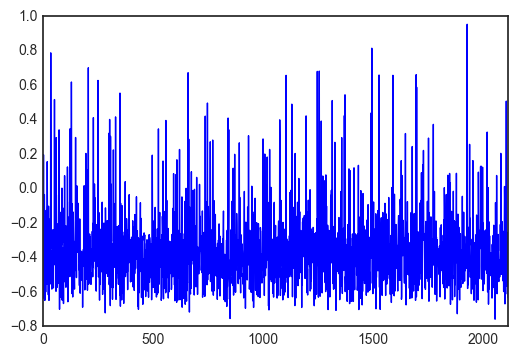

In [170]:
np.log10(np.mean(np.abs(prc_fuse),axis = 1)).plot()
plt.show()

In [173]:
np.mean(np.mean(np.abs(prc_fuse),axis = 1) >= 1.0)

0.059045819555975439

In [177]:
(prc_fuse >= 1.0).corr()

,TARGET_1,TARGET_2,TARGET,TARGET_4,TARGET_5,TARGET_6,TARGET_7,TARGET_8,TARGET_9,TARGET_10,...,TARGET_309,TARGET_310,TARGET_311,TARGET_312,TARGET_313,TARGET_314,TARGET_315,TARGET_316,TARGET_317,TARGET_318
TARGET_1,1.000000,0.133422,0.750573,0.828522,0.651363,0.281460,0.810919,0.244870,0.575859,0.755485,...,0.468608,0.720235,0.738082,0.672288,0.570163,0.580252,0.433649,0.379525,0.551535,0.330768
TARGET_2,0.133422,1.000000,0.154392,0.096305,0.230538,0.593919,0.132256,0.266763,0.306133,0.138997,...,0.354551,0.048364,0.248115,0.161027,0.241601,0.065067,0.226707,0.524070,0.046292,0.402987
TARGET,0.750573,0.154392,1.000000,0.711367,0.672175,0.295527,0.695090,0.284845,0.596671,0.706786,...,0.522633,0.677134,0.701216,0.665996,0.607338,0.581748,0.451495,0.384665,0.548284,0.352928
TARGET_4,0.828522,0.096305,0.711367,1.000000,0.609952,0.223612,0.817916,0.238920,0.523262,0.779775,...,0.434908,0.735784,0.686707,0.629967,0.539165,0.583792,0.409269,0.310450,0.533605,0.295796
TARGET_5,0.651363,0.230538,0.672175,0.609952,1.000000,0.348424,0.606114,0.336689,0.614737,0.642696,...,0.546569,0.545203,0.607553,0.620156,0.562519,0.535851,0.490227,0.419018,0.457461,0.403103
TARGET_6,0.281460,0.593919,0.295527,0.223612,0.348424,1.000000,0.274284,0.394974,0.461293,0.270378,...,0.514531,0.169667,0.379527,0.275558,0.362366,0.196445,0.401535,0.484737,0.156307,0.524500
TARGET_7,0.810919,0.132256,0.695090,0.817916,0.606114,0.274284,1.000000,0.290161,0.562880,0.747941,...,0.484536,0.684699,0.693130,0.656029,0.550707,0.579798,0.458068,0.352712,0.529574,0.307589
TARGET_8,0.244870,0.266763,0.284845,0.238920,0.336689,0.394974,0.290161,1.000000,0.362347,0.273874,...,0.499175,0.176915,0.308409,0.293477,0.343054,0.290340,0.406003,0.254359,0.169560,0.365609
TARGET_9,0.575859,0.306133,0.596671,0.523262,0.614737,0.461293,0.562880,0.362347,1.000000,0.542390,...,0.586272,0.448893,0.619018,0.578084,0.577633,0.476090,0.560565,0.530908,0.422595,0.500560
TARGET_10,0.755485,0.138997,0.706786,0.779775,0.642696,0.270378,0.747941,0.273874,0.542390,1.000000,...,0.486005,0.713781,0.626861,0.615298,0.554683,0.533379,0.454823,0.372562,0.530049,0.340634


In [187]:
fuse_X = pd.read_csv('fused_X.csv',sep = ';')
fuse_Y = pd.read_csv('fused_Y.csv',sep = ';')

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = fuse_X.copy()

fuse_Y = fuse_Y.fillna(fuse_Y.median())

del fuse_Y['date']

y = fuse_Y.values[:,0]

del copy['date']

X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
print(np.mean(np.abs(y_pred - y_test)/(y_test)))

0.222068368296


In [188]:
fuse_X = pd.read_csv('fused_X.csv',sep = ';')
fuse_Y = pd.read_csv('fused_Y.csv',sep = ';')

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = fuse_X.copy()

fuse_Y = fuse_Y.fillna(fuse_Y.median())

del fuse_Y['date']

y = fuse_Y.values[:,210]

del copy['date']

X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
print(np.mean(np.abs(y_pred - y_test)/(y_test)))

0.733928500814


In [189]:
model.feature_importances_

array([ 0.01584786,  0.0110935 ,  0.        ,  0.00633914,  0.00475436,
        0.        ,  0.00475436,  0.00792393,  0.00158479,  0.        ,
        0.        ,  0.00158479,  0.        ,  0.        ,  0.        ,
        0.00633914,  0.        ,  0.        ,  0.        ,  0.00158479,
        0.        ,  0.        ,  0.        ,  0.00950872,  0.        ,
        0.        ,  0.00158479,  0.00158479,  0.00633914,  0.        ,
        0.00158479,  0.00158479,  0.        ,  0.00158479,  0.00633914,
        0.        ,  0.00475436,  0.        ,  0.00158479,  0.00792393,
        0.        ,  0.00316957,  0.00316957,  0.00475436,  0.00316957,
        0.00316957,  0.00316957,  0.00316957,  0.        ,  0.        ,
        0.00633914,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00158479,  0.00158479,  0.        ,  0.        ,  0.        ,
        0.00633914,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00158479,  0.00475436,  0.00158479,  0.        ,  0.00

In [225]:
v = summary[summary['MEAN'] <= -0.95]['PRODUCT'].values

In [226]:
groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])

In [232]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.loc[indices].copy()

y = copy['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.34503544124837288

In [233]:
y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test-0.02)/(y_test))

0.30221844376662682

In [243]:
v = summary[summary['MEAN'] > -0.75]['PRODUCT'].values

groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])

In [244]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.loc[indices].copy()

y = copy['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.25410500668719149

In [245]:
y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test-0.02)/(y_test))

0.224791247076287

In [256]:
v = summary[(summary['MEAN'] < -0.75) & (summary['MEAN'] >= -0.95)]['PRODUCT'].values

groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])

In [260]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


copy = data.loc[indices].copy()

y = copy['TARGET'].values

del copy['TARGET']
             
X = copy.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 1)

model = XGBRegressor(booster = 'gbtree',n_jobs = 5)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/(y_test))

0.26105619587570744

In [261]:
y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test-0.02)/(y_test))

0.2335432557374002

In [251]:
v

array([112, 312, 281, 264, 316, 298, 154, 127, 121, 274, 249, 294,  99,
        93, 282,   3,   2,  94, 270, 257, 118, 265,  22,   6,  35, 125,
       171, 286, 130, 185, 147,  79, 114, 190, 144, 135, 273, 195, 214,
        87, 231, 223, 119,  19, 308, 124, 189,  27, 314,   8, 197, 262,
       300, 244, 258, 276, 243,  81, 301,  96, 204,  23, 208], dtype=int64)

In [262]:
data.head()

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,47,48,49,50,51,52,53,COEFFICIENT_EXPONENTIAL_A,COEFFICIENT_EXPONENTIAL_B,ERROR_FIT_EXPONENTIAL
0,1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,...,0.100770,0.097541,0.094415,0.091389,0.088460,0.085626,0.082881,-0.764036,-1.726308,0.105259
1,2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,...,0.048404,0.047972,0.047543,0.047118,0.046697,0.046279,0.045865,-2.606141,-0.475903,0.038854
2,3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,...,0.184205,0.180291,0.176461,0.172712,0.169043,0.165452,0.161937,-0.682478,-1.138068,0.150655
3,4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,...,0.092347,0.090046,0.087802,0.085614,0.083480,0.081400,0.079371,-1.196095,-1.337522,0.077895
4,5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,...,0.048743,0.048480,0.048218,0.047957,0.047698,0.047440,0.047184,-2.766547,-0.287154,0.071397


In [274]:
v = summary[summary['MEAN'] > -0.75]['PRODUCT'].values

groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])
    
data_50.loc[indices].to_csv('DATA_HIGH_VOL.csv',sep = ';',index = False)

In [275]:
v = summary[summary['MEAN'] <= -0.95]['PRODUCT'].values

groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])
    
data_50.loc[indices].to_csv('DATA_LOW_VOL.csv',sep = ';',index = False)

In [276]:
v = summary[(summary['MEAN'] < -0.75) & (summary['MEAN'] >= -0.95)]['PRODUCT'].values

groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])
    
data_50.loc[indices].to_csv('DATA_MID_VOL.csv',sep = ';',index = False)

In [273]:
v = summary[summary['MEAN'] > -0.75]['PRODUCT'].values


groups = data.groupby(by = 'product_id').groups
indices = np.array([])

for k in v:
    indices = np.append(indices,groups[k])
    

data.loc[indices]['TARGET']

111.0       0.145780
429.0       0.266205
747.0       0.551645
1313.0      0.121376
1631.0      0.131722
1949.0      0.355206
2256.0      0.057365
2559.0      0.246439
2877.0      0.156582
3195.0      0.134433
3513.0      0.152467
3831.0      0.254628
4149.0      0.185028
4950.0      0.168493
5267.0      0.222895
5584.0      0.122301
5902.0      0.439554
6211.0      0.210317
6765.0      0.113713
7332.0      0.180488
7897.0      0.204750
8215.0      0.230821
8782.0      0.338293
9349.0      0.312084
10413.0     1.809992
10731.0     0.733996
11048.0     0.162041
11359.0     0.157111
11661.0     0.085764
11970.0     0.134036
              ...   
627505.0    0.282777
627817.0    0.184256
628082.0    0.663005
628382.0    0.145494
628700.0    0.189873
629018.0    0.152593
629278.0    0.385983
629573.0    0.166041
629890.0    0.219088
630208.0    0.217964
630475.0    0.180409
630760.0    0.286694
631072.0    0.401980
631338.0    0.419494
631638.0    0.386547
631956.0    0.227497
632259.0    0

In [277]:
pd.read_csv('DATA_HIGH_VOL.csv',sep = ';')

,ERROR_FIT_EXPONENTIAL,volatility 13:55:00,volatility 13:50:00,volatility 13:45:00,volatility 13:10:00,volatility 13:30:00,STD_RETURNS,P5_STD_RETURNS,HIGH_POINT_VOLATILITY,34,...,volatility 09:45:00,P2_TREND_VOLATILITY,volatility 13:05:00,volatility 09:50:00,volatility 10:00:00,volatility 12:25:00,volatility 13:00:00,P4_TREND_VOLATILITY,49,TARGET
0,0.090549,0.059323,0.237292,0.065803,0.065970,0.249700,0.942809,0.899200,0.771263,0.150335,...,0.482324,0.586259,0.342948,0.300494,0.143594,0.172057,0.118981,0.564265,0.109295,0.145780
1,0.137239,0.136293,0.353199,0.779225,0.086628,0.050863,0.999314,0.999405,1.064886,0.175423,...,0.403887,0.796781,0.101727,0.097074,0.325845,0.066223,0.294655,0.496397,0.134973,0.266205
2,0.329304,0.281087,1.244763,0.231561,0.530523,0.372690,0.997253,0.970431,2.962674,0.565409,...,0.227816,0.816187,0.505225,2.962674,0.605340,0.780313,0.678896,0.689110,0.515272,0.551645
3,0.085517,0.098189,0.132625,0.078543,0.088213,0.029457,0.959395,0.927836,0.722832,0.099885,...,0.153143,0.690208,0.029389,0.207484,0.093832,0.058846,0.098066,0.367387,0.067230,0.121376
4,0.077133,0.049938,0.104055,0.091601,0.099591,0.078976,0.963675,0.959340,0.609781,0.081069,...,0.177552,0.316963,0.041507,0.190107,0.053669,0.066388,0.153619,0.497115,0.062595,0.131722
5,0.157707,0.929594,0.923224,0.227450,0.294686,0.257317,0.986361,0.980184,0.994002,0.258963,...,0.448209,0.586605,0.082964,0.622210,0.574284,0.301697,0.158520,0.618745,0.225929,0.355206
6,0.072022,0.036520,0.000000,0.036510,0.109645,0.109503,0.768909,0.661494,0.524682,0.029598,...,0.036406,0.000000,0.109560,0.182267,0.122115,0.012183,0.133732,0.382282,0.017739,0.057365
7,0.146468,0.155153,0.149923,0.219355,0.230240,0.112417,0.999314,0.970431,1.150457,0.191326,...,0.771732,0.679930,0.134029,0.417261,0.991673,0.145603,0.498474,0.562855,0.133951,0.246439
8,0.108758,0.042607,0.120666,0.170430,0.099463,0.199077,0.963675,0.891231,1.152130,0.170126,...,0.388007,0.589462,0.099538,0.579693,0.286268,0.214471,0.149376,0.476137,0.112692,0.156582
9,0.074789,0.069031,0.230031,0.015361,0.107676,0.046116,0.955814,0.946864,0.544308,0.091908,...,0.527621,0.503975,0.069250,0.131888,0.139637,0.061839,0.115455,0.354884,0.059942,0.134433
